# plotting


In [10]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

In [2]:
%store -r log_text
from micropython_magic.memoryinfo import MemoryInfoList
mi_list = MemoryInfoList(show_free=False)
print(f"Loaded and parsed {len(mi_list.parse_log(log_text))} memory_info records from the log file")

Loaded and parsed 289 memory_info records from the log file


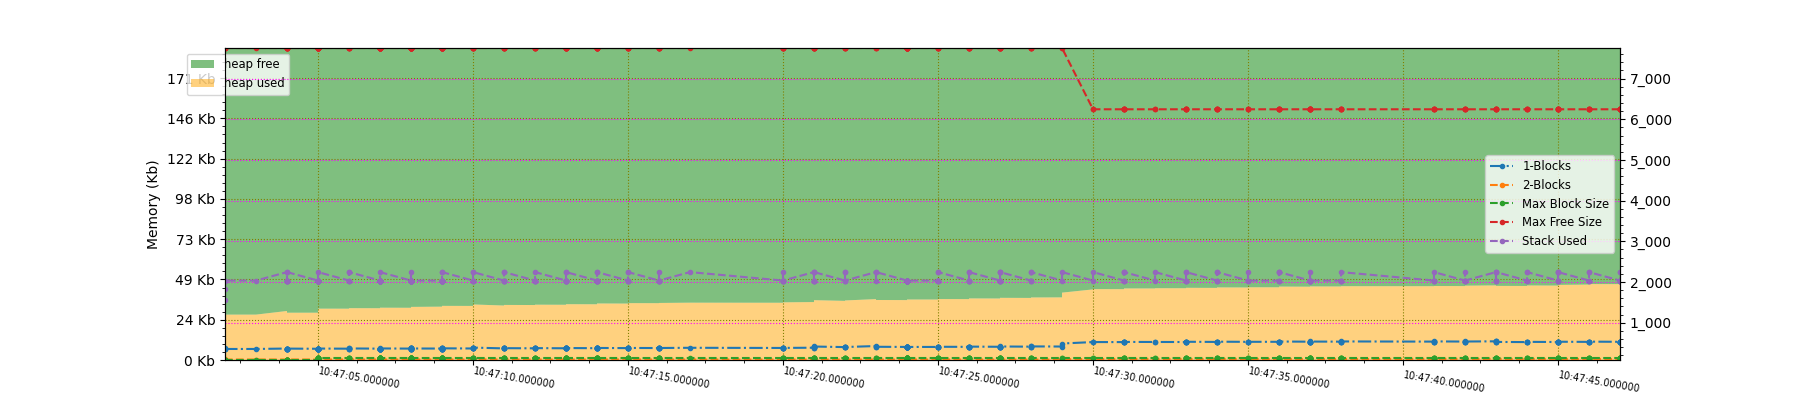

In [3]:
# clean up previous plot - save memory
# plt.close()

fig1 = mi_list.plot(
    free=True,
    # stack_total=True,
    one_blocks=True,
    two_blocks=True,
    max_block_size=True,
    max_free_size=True,
    stack_used=True,
    size=(18, 4),
)

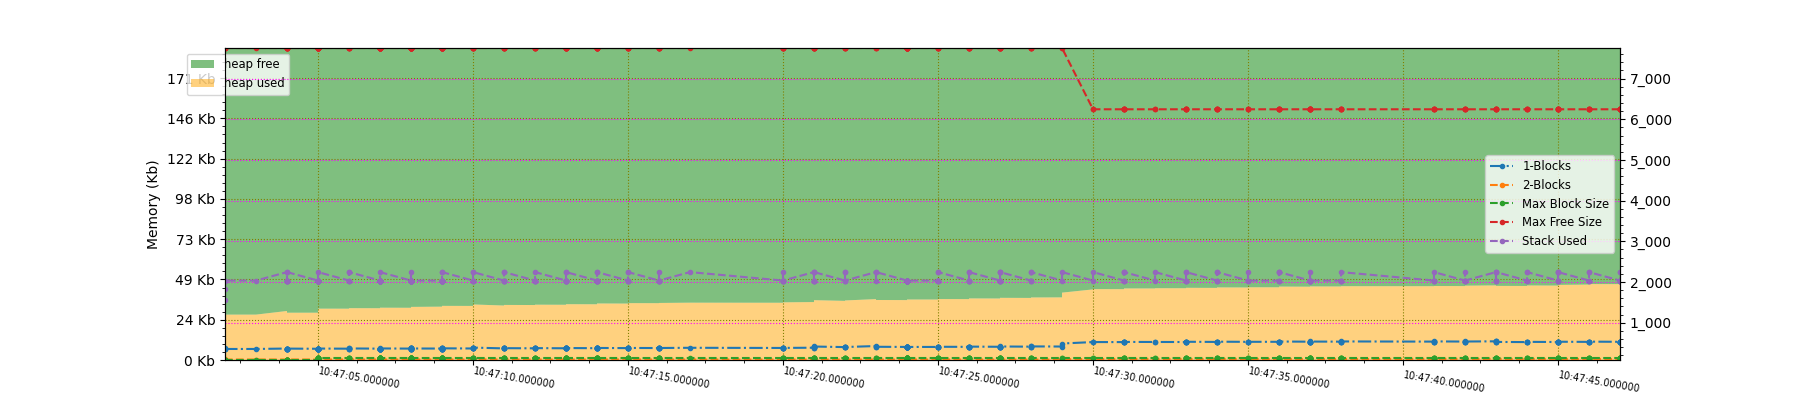

In [4]:
plt.show(fig1)

You can also call `display` on `fig.canvas` to display the interactive plot anywhere in the notebooke


Hover Over :

- https://stackoverflow.com/questions/7908636/how-to-add-hovering-annotations-to-a-plot/47166787#47166787
- https://stackoverflow.com/questions/55891285/how-to-make-labels-appear-when-hovering-over-a-point-in-multiple-axis/55892690#55892690
-


In [13]:
# %%micropython
from micropython import mem_info
from time import gmtime


def log_mem(id="", verbose=0):
    print(f"\n*** Memory info {id} ***")
    # add time to the log
    print(f"time:{gmtime()}")
    if verbose:
        print(mem_info(1))
    else:
        print(mem_info())
    print("***********************\n")

[]

In [17]:
# %%micropython
import time

log_mem("before")
for n in range(100):
    block = bytearray(1000)
    log_mem(f"stap {n}")
    time.sleep_us(n)

log_mem("after")

In [13]:
output = _
# log_text = __
log_text = list(output.data)

In [14]:
from micropython_magic.memoryinfo import MemoryInfoList

mi_list = MemoryInfoList(show_free=False)
print(f"Loaded and parsed {len(mi_list.parse_log(log_text))} memory_info records from the log file")

Loaded and parsed 102 memory_info records from the log file


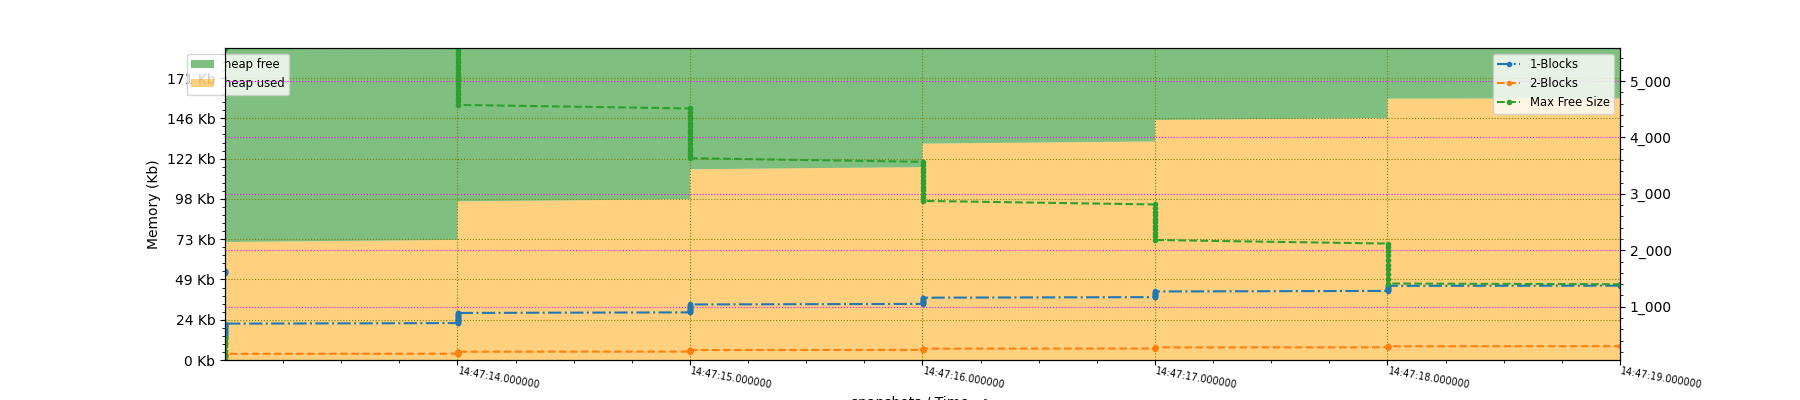

In [16]:
p2 = mi_list.plot(
    time_axis=True,
    free=True,
    # stack_total=True,
    one_blocks=True,
    two_blocks=True,
    # max_block_size=True,
    max_free_size=True,
    # stack_used=True,
    size=(18, 4),
)

In [9]:

%mpy import time
dt = %mpy --eval  time.localtime()
dt


[2020, 1, 1, 11, 23, 14, 2, 1]

In [10]:
from datetime import datetime

# dt = (2021, 1, 3, 18, 5, 44, 6, 3)
dt = %mpy --eval  time.localtime()
dt2 = datetime(*dt[:-1])
# convert to np datetime 
dt3 = np.datetime64(dt2)


dt, dt2, dt3



([2020, 1, 1, 11, 23, 15, 2, 1],
 datetime.datetime(2020, 1, 1, 11, 23, 15, 2),
 numpy.datetime64('2020-01-01T11:23:15.000002'))

In [11]:
datetime.now()

datetime.datetime(2023, 6, 25, 17, 37, 37, 533134)